In [1]:
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array, argmax, random, take
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Concatenate, Dropout, LayerNormalization, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [2]:
# Open the deu file and read the sentence pairs into an array
deu_eng = []
with open("deu.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split("\t")  # Split by tab and remove any extra whitespace
        source_sentence = parts[0]
        target_sentence = parts[1]
        deu_eng.append([source_sentence, target_sentence])  # Store as a pair of strings

In [3]:
deu_eng = array(deu_eng)
deu_eng = deu_eng[:50000,:]
deu_eng.shape

(50000, 2)

In [4]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ['I heard you did well.',
        'Ich habe gehört, Sie haben gut abgeschnitten.'],
       ['I heard you laughing.', 'Ich habe dich lachen gehört.'],
       ['I heard you laughing.', 'Ich habe euch lachen gehört.']],
      dtype='<U537')

In [5]:
# Remove punctuation and convert to lowercase
deu_eng[:, 0] = [s.translate(str.maketrans('', '', string.punctuation)).lower() for s in deu_eng[:, 0]]
deu_eng[:, 1] = [s.translate(str.maketrans('', '', string.punctuation)).lower() for s in deu_eng[:, 1]]
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['i heard you did well',
        'ich habe gehört sie haben gut abgeschnitten'],
       ['i heard you laughing', 'ich habe dich lachen gehört'],
       ['i heard you laughing', 'ich habe euch lachen gehört']],
      dtype='<U537')

In [6]:
# Remove duplicate rows
deu_eng = np.unique(deu_eng, axis=0)
deu_eng.shape

(49752, 2)

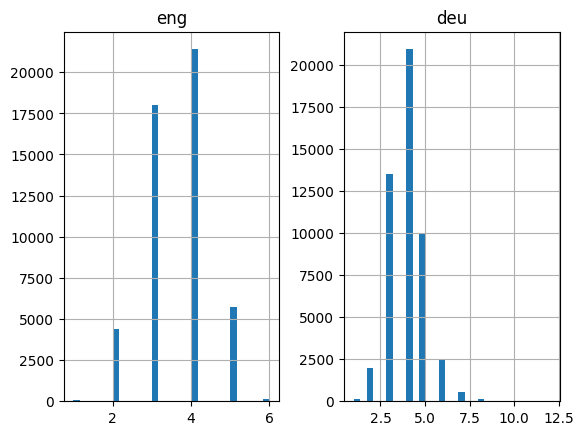

In [7]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [8]:
from collections import Counter

# Calculate max, min, and most frequent lengths
eng_max = max(eng_l)
eng_min = min(eng_l)
eng_most_common_length = Counter(eng_l).most_common(1)[0]  # (length, count)

deu_max = max(deu_l)
deu_min = min(deu_l)
deu_most_common_length = Counter(deu_l).most_common(1)[0]  # (length, count)

print(f"English - Max Length: {eng_max}, Min Length: {eng_min}, Most Frequent Length: {eng_most_common_length}")
print(f"German - Max Length: {deu_max}, Min Length: {deu_min}, Most Frequent Length: {deu_most_common_length}")

English - Max Length: 6, Min Length: 1, Most Frequent Length: (4, 21394)
German - Max Length: 12, Min Length: 1, Most Frequent Length: (4, 20950)


In [9]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6098


In [11]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10071


In [12]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [14]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [15]:
# example
trainX[5]

array([   2,   67, 4539,    0,    0,    0,    0,    0], dtype=int32)

In [16]:
import tensorflow as tf
trainX_tensor = tf.convert_to_tensor(trainX, dtype=tf.int32)
trainY_tensor = tf.convert_to_tensor(trainY, dtype=tf.int32)
testX_tensor = tf.convert_to_tensor(testX, dtype=tf.int32)
testY_tensor = tf.convert_to_tensor(testY, dtype=tf.int32)

In [25]:
def define_improved_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    # Encoder
    encoder_inputs = Input(shape=(in_timesteps,))

    # Embedding layer with dropout
    emb = Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)(encoder_inputs)
    emb = Dropout(0.2)(emb)

    # Bidirectional LSTM layers with residual connections
    encoder_lstm1 = Bidirectional(LSTM(units, return_sequences=True))(emb)
    encoder_lstm1 = LayerNormalization()(encoder_lstm1)
    encoder_lstm1 = Dropout(0.2)(encoder_lstm1)

    encoder_lstm2 = Bidirectional(LSTM(units, return_sequences=True))(encoder_lstm1)
    encoder_lstm2 = LayerNormalization()(encoder_lstm2)
    encoder_lstm2 = Dropout(0.2)(encoder_lstm2)

    # Final encoder LSTM
    encoder_lstm3 = Bidirectional(LSTM(units))(encoder_lstm2)
    encoder_lstm3 = LayerNormalization()(encoder_lstm3)

    # Decoder
    decoder = RepeatVector(out_timesteps)(encoder_lstm3)

    # Decoder LSTM layers
    decoder = LSTM(units*2, return_sequences=True)(decoder)
    decoder = LayerNormalization()(decoder)
    decoder = Dropout(0.2)(decoder)

    decoder = LSTM(units*2, return_sequences=True)(decoder)
    decoder = LayerNormalization()(decoder)
    decoder = Dropout(0.2)(decoder)

    # Output layer
    outputs = Dense(out_vocab, activation='softmax')(decoder)

    # Create model
    model = Model(inputs=encoder_inputs, outputs=outputs)

    return model

In [33]:
def train_model(model, x_train, y_train, batch_size=64, epochs=50):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
    return model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=callbacks
    )

def compile_model(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [34]:
# Create and compile model
model = define_improved_model(
    in_vocab=deu_vocab_size,
    out_vocab=eng_vocab_size,
    in_timesteps=deu_length,
    out_timesteps=eng_length,
    units=512
)
model = compile_model(model)

# Train model
history = train_model(model, trainX, trainY)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 76s 131ms/step - accuracy: 0.5977 - loss: 2.9370 - val_accuracy: 0.6361 - val_loss: 2.3546
Epoch 2/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 64s 129ms/step - accuracy: 0.6429 - loss: 2.2668 - val_accuracy: 0.6682 - val_loss: 2.0884
Epoch 3/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.6750 - loss: 1.9522 - val_accuracy: 0.6938 - val_loss: 1.8700
Epoch 4/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 64s 128ms/step - accuracy: 0.7012 - loss: 1.6826 - val_accuracy: 0.7080 - val_loss: 1.7237
Epoch 5/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.7177 - loss: 1.4887 - val_accuracy: 0.7200 - val_loss: 1.6317
Epoch 6/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.7324 - loss: 1.3251 - val_accuracy: 0.7286 - val_loss: 1.5582
Epoch 7/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.7442 - loss: 1.2020 - val_accuracy: 0.7372 - val_loss: 1.5150
Epoch 8/50
498/498 ━━━━━━━━━━━━━━━━━━━━ 64s 128ms/step - accuracy: 0.7606 - loss: 1

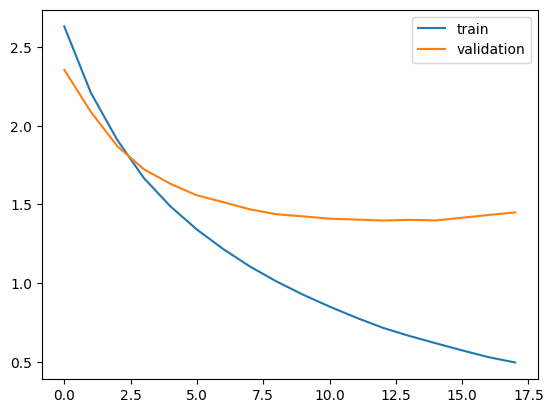

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [36]:
# Use the predict method to get the probabilities
preds_prob = model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

# Convert probabilities to class predictions
preds = np.argmax(preds_prob, axis=-1)  # Get the index of the max probability for each sample

311/311 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


In [37]:
# Create a reverse dictionary for faster lookup
index_word = {index: word for word, index in eng_tokenizer.word_index.items()}

def get_word(n):
    # Return the word corresponding to the index n directly
    return index_word.get(n, None)

preds_text = []

# Iterate over each sequence in preds
for seq in preds:
    temp = []
    previous_word = None
    for j in range(len(seq)):
        current_word = get_word(seq[j])  # Get the word for the predicted index

        if current_word and current_word != previous_word:  # Append if it's not None and different from the previous
            temp.append(current_word)
        previous_word = current_word  # Update previous_word

    preds_text.append(' '.join(temp))  # Join the list into a single string

In [38]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [40]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
16,does tom eat grapes,did tom eat too
3687,im not really sick,im not really sick
3739,i cant stand it,i dont wear funerals
5784,how deep is it here,how bad is it here
7507,thats my cat,this is my cat
96,its urgent,its disappointing
4434,i bet you know this,i know you do that
3906,its time to go,we have to go
4841,did tom lie to mary,did tom ask mary
5258,im just watching,im not dead
